In [1]:
#@markdown Utility function (run on each Runtime restart)

import os
import sys
# import gdown
import zipfile
import pandas as pd
    
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')
print('DEVICE:', DEVICE)

from IPython.display import clear_output

DEVICE: cuda


# Function for Google Drive Extraction

In [2]:
def download_from_gdrive(gdrive_id, filename):
    url = 'https://drive.google.com/uc?id=' + gdrive_id[filename]
    gdown.download(url)

In [3]:
# Check the path of deephumor-master repository
os.getcwd()

'C:\\Users\\frank\\OneDrive\\Desktop\\7643_Project\\deephumor-master'

In [4]:
sys.path.append('./deephumor')

# 1. Data preparation

In [5]:
# Generate a dictionary for google drive ids of files to download
gdrive_id = pd.read_csv('file_ids.txt', sep = '\t', header = None).set_index(0).to_dict()[1]

## 1.1. Data

Load the dataset from Google Drive:

In [6]:
os.getcwd()

'C:\\Users\\frank\\OneDrive\\Desktop\\7643_Project\\deephumor-master'

In [7]:
# Check the path of dataset
DATA_DIR = 'C:/Users/frank/OneDrive/Desktop/7643_Project/dataset/memes900k'

# Download from the Google Drive and set the path
# download_from_gdrive(gdrive_id, 'memes900k.zip')
# DATA_DIR = 'memes900k'


CAPTIONS_FILE = os.path.join(DATA_DIR, 'captions_train.txt')

## 1.2 Vocabulary

Before loading and testing the models it is necessary to build the token vocabularies used by the models.

Original vocavularies are built based on tokens the `captions_train.txt` file using `build_vocab_from_file` function. The function is deterministic and you will obtain the same vocabulary used during the experiments by setting `min_df=5`.

Vocabularies used by the models can also be loaded and built from Google Drive.

Set `LOAD_VOCABULARY = False` to built vocabularies from scratch. Overwise, the files will be loaded from Google Drive.


In [8]:
# Download vocab.zip from Google Drive

fname = 'vocab.zip'

download_from_gdrive(gdrive_id, fname)

with zipfile.ZipFile(fname,"r") as zip_ref:
    zip_ref.extractall()

NameError: name 'gdown' is not defined

In [9]:
#@title Word and Chararacter Vocab

from deephumor.data.vocab import Vocab, build_vocab_from_file
from deephumor.data.tokenizers import WordPunctTokenizer, CharTokenizer

LOAD_VOCABULARY = True #@param {type:"boolean"}
MIN_DF = 5 #@param {type:"integer"}

tokenizer_words = WordPunctTokenizer()
tokenizer_chars = CharTokenizer()

if LOAD_VOCABULARY:
    print('Loading vocabularies from Google Drive')

    vocab_words = Vocab.load('vocab/vocab_words.txt')
    vocab_chars = Vocab.load('vocab/vocab_chars.txt')
    clear_output()

    print('Loaded vocabularies from Google Drive')
else:
    print(f'Building WordPunct Vocabulary from {CAPTIONS_FILE}, min_df={MIN_DF}')
    vocab_words = build_vocab_from_file(CAPTIONS_FILE, tokenizer_words, min_df=MIN_DF)

    print(f'Building Character Vocabulary from {CAPTIONS_FILE}, min_df={MIN_DF}')
    vocab_chars = build_vocab_from_file(CAPTIONS_FILE, tokenizer_chars, min_df=MIN_DF)


print('\nVocabulary sizes:')
print('WordVocab:', len(vocab_words))
print('CharVocab:', len(vocab_chars))

Loaded vocabularies from Google Drive

Vocabulary sizes:
WordVocab: 36541
CharVocab: 71


## 1.3 MemeDataset

Build Word- and Character-level `MemeDataset`s usign the defined vocabularies and tokenizers. 

Use `NUM_CLASSES` to limit the number of templates to load (max. is 300, for training the models only 200 were used).



In [10]:
#@title Build `MemeDataset`

from deephumor.data import MemeDataset

# use this to limit the dataset size (300 classes in total)
NUM_CLASSES = 200 #@param {type:"slider", min:1, max:300, step:1}  
PAD_IDX = vocab_words.stoi['<pad>']

from torchvision import transforms
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

splits = ['train', 'val', 'test']

datasets_words = {
    # WORD-LEVEL
    split: MemeDataset(DATA_DIR, vocab_words, tokenizer_words, image_transform=image_transform,
                       num_classes=NUM_CLASSES, split=split, preload_images=True)
    for split in splits
}

datasets_chars = {
    # CHAR-LEVEL
    split: MemeDataset(DATA_DIR, vocab_chars, tokenizer_chars, image_transform=image_transform,
                       num_classes=NUM_CLASSES, split=split, preload_images=True)
    for split in splits
}

# 2. Models

In [11]:
#@markdown Model loading utilities

from deephumor.models import (
    CaptioningLSTM, 
    CaptioningLSTMWithLabels, 
    CaptioningTransformerBase,
    CaptioningTransformer
)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def load_and_build_model(ckpt_path, model_class):
    print(f'Building {model_class.__name__} model')
    model = model_class.from_pretrained(ckpt_path).to(DEVICE)
    print(f'Built and loaded {model_class.__name__} model from {ckpt_path}')
    print('# parameters:', count_parameters(model))

    return model

FILE_TO_CLASS = {
    'LSTMDecoderWords.best.pth': CaptioningLSTM,
    'LSTMDecoderChars.best.pth': CaptioningLSTM,
    'LSTMDecoderWithLabelsWords.best.pth': CaptioningLSTMWithLabels,
    'LSTMDecoderWithLabelsChars.best.pth': CaptioningLSTMWithLabels,
    'TransformerDecoderBaseWords.best.pth': CaptioningTransformerBase,
    'TransformerDecoderBaseChars.best.pth': CaptioningTransformerBase,
    'TransformerDecoderWords.best.pth': CaptioningTransformer,
    'TransformerDecoderChars.best.pth': CaptioningTransformer
}

IMPORTANT: if some cell in this section crashed, run it again, it should be fine

# Meme Generation

In [12]:
#@title Meme generation and captioning function

IMG_DIR = 'images_inference/transform/unhateful'

from PIL import Image
from deephumor.experiments import text_to_seq, seq_to_text, split_caption
from deephumor.imaging import memeify_image
FONT_PATH = 'deephumor/fonts/impact.ttf'

def get_a_meme(model, img_torch, img_pil, caption, T=1., beam_size=7, top_k=50, 
               labels = None, mode = 'word', device=DEVICE):
    if mode == 'word':
        vocabulary = vocab_words
        datasets = datasets_words
        delimiter=' '
        max_len = 32
    else:
        vocabulary = vocab_chars
        datasets = datasets_chars
        delimiter=''
        max_len = 128
    
    model.eval()
    if caption is not None:
        caption_tensor = torch.tensor(datasets['train']._preprocess_text(caption)[:-1]).unsqueeze(0).to(device)
        # caption_tensor = torch.tensor(datasets['train']._preprocess_text(caption)).unsqueeze(0).to(device)
    else:
        caption_tensor = None

    if labels is None:
        with torch.no_grad():
            output_seq = model.generate(
                image=img_torch, caption=caption_tensor,
                max_len=max_len, beam_size=beam_size, temperature=T, top_k=top_k
            )
    else:
        with torch.no_grad():
            output_seq = model.generate(
                image=img_torch, label=labels, caption=caption_tensor,
                max_len=max_len, beam_size=beam_size, temperature=T, top_k=top_k
            )
    
    pred_seq = output_seq
    text = seq_to_text(pred_seq, vocab=vocabulary, delimiter=delimiter)

    top, bottom = split_caption(text, num_blocks=2)
    # print(top)
    # print(bottom)

    return memeify_image(img_pil, top, bottom, font_path=FONT_PATH)

# GENERATE

You can either use images from the dataset or use images of your own (unseen during the traing). For the latter download your image to the Images_inference folder. It is also possible to take images from that folder. 

One more option is to select the beginning of your future generated meme, and by doing so inserting some context into the model. To do so change `caption = None` to your sring.

In [13]:
# # Image from dataset
# label = 'PTSD Karate Kyle' 
# labels = torch.tensor(datasets_words['train']._preprocess_text(label)).unsqueeze(0).cuda()
# img_torch = datasets_words['train'].images[label]
# img_pil = Image.open(datasets_words['train'].templates[label])
# img_torch = img_torch.unsqueeze(0).cuda()
# caption = None # "Your mom"

## Images from the dataset

In the cell below you can input the corresonding `label` of the template, the full list of templates is in memes900k/templates.txt. You can use labels only in models with that feature, namely `ch_lstm_model_labels`, `w_lstm_model_labels`. To do so, during generation in function `get_a_meme` write `labels=labels`.

## New images

To generate memes from unseen images, uncomment the cell below. Change the name of a picture from `druzko` to the name of your picture.

In [76]:
# New image
label = 'Willy' 
# label = 'Bad Luck Brian' 
# label = None

image_name = '46508.png'

labels = torch.tensor(datasets_words['train']._preprocess_text(label)).unsqueeze(0).cuda()
labels_c = torch.tensor(datasets_chars['train']._preprocess_text(label)).unsqueeze(0).cuda()

img_pil = Image.open(os.path.join(IMG_DIR, image_name))

img_torch = image_transform(img_pil)
img_torch = img_torch.unsqueeze(0).cuda()
# img_torch = img_torch.unsqueeze(0)
caption = None #"so tired" # "hey girl"

## 2.1. Word-based models

### 2.1.1. LSTM Decoder

In [32]:
#@markdown Load and build `w_lstm_model`

ckpt_path = 'LSTMDecoderWords.best.pth'

# download_from_gdrive(gdrive_id, ckpt_path)

model_class = FILE_TO_CLASS[ckpt_path]

w_lstm_model = load_and_build_model(ckpt_path, model_class)

Building CaptioningLSTM model
Built and loaded CaptioningLSTM model from LSTMDecoderWords.best.pth
# parameters: 44808381


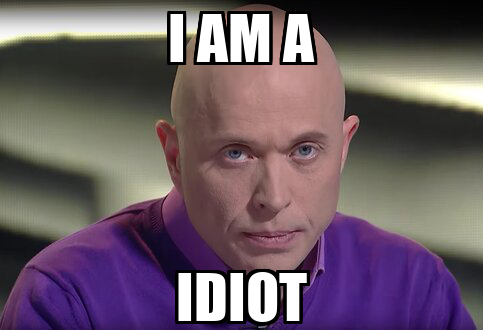

In [33]:
w_lstm_model.cuda()

get_a_meme(
    model=w_lstm_model, T=1.3, 
    beam_size=10,
    top_k=100,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='word',
    device='cuda'
)

### 2.1.2. LSTM Decoder with labels

In [ ]:
#@markdown Load and build `w_lstm_model_labels`

ckpt_path = 'LSTMDecoderWithLabelsWords.best.pth'

# download_from_gdrive(gdrive_id, ckpt_path)

model_class = FILE_TO_CLASS[ckpt_path]

w_lstm_model_labels = load_and_build_model(ckpt_path, model_class)

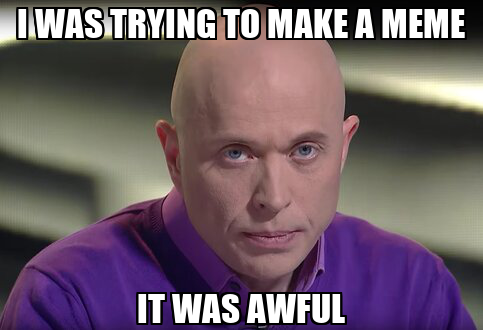

In [37]:
w_lstm_model_labels.cuda()

get_a_meme(
    model=w_lstm_model_labels, T=1.3, 
    beam_size=10,
    top_k=100,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=labels, 
    mode='word',
    device='cuda'
)

### 2.1.3. Tranformer with global image embedding

In [77]:
#@markdown Load and build `w_transformer_base_model`

ckpt_path = 'TransformerDecoderBaseWords.best.pth'

# download_from_gdrive(gdrive_id, ckpt_path)

model_class = FILE_TO_CLASS[ckpt_path]

w_transformer_base_model = load_and_build_model(ckpt_path, model_class)

Building CaptioningTransformerBase model
Built and loaded CaptioningTransformerBase model from TransformerDecoderBaseWords.best.pth
# parameters: 48027325


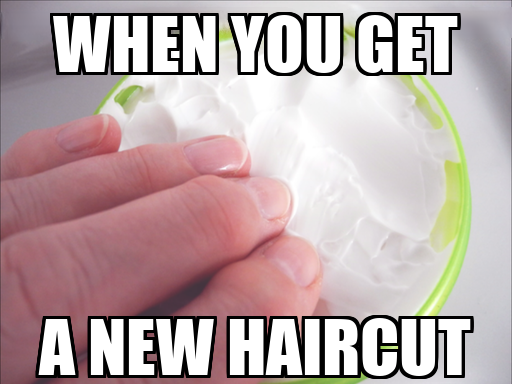

In [107]:
w_transformer_base_model.cuda()

get_a_meme(
    model=w_transformer_base_model, T=1.0, 
    beam_size=10,
    top_k=70,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='word',
    device='cuda'
)

### 2.1.4. Tranformer with spacial image features

In [40]:
#@markdown Load and build `w_transformer_model`

ckpt_path = 'TransformerDecoderWords.best.pth'

# download_from_gdrive(gdrive_id, ckpt_path)

model_class = FILE_TO_CLASS[ckpt_path]

w_transformer_model = load_and_build_model(ckpt_path, model_class)

Building CaptioningTransformer model
Built and loaded CaptioningTransformer model from TransformerDecoderWords.best.pth
# parameters: 51182269


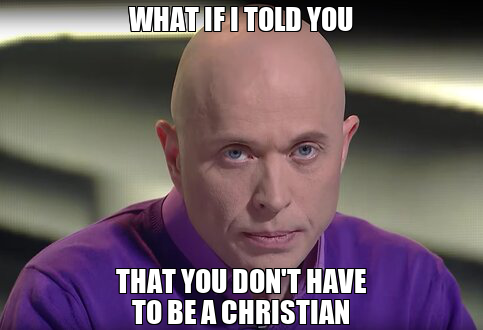

In [41]:
w_transformer_model.cuda()

get_a_meme(
    model=w_transformer_model, T=1.0, 
    beam_size=10,
    top_k= 70,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='word',
    device='cuda'
)

## 2.2. Character-based models

### 2.2.1. LSTM Decoder

In [29]:
os.getcwd()

'C:\\Users\\frank\\OneDrive\\Desktop\\7643_Project\\deephumor-master'

In [ ]:
#@markdown Load and build `ch_lstm_model`

ckpt_path = 'LSTMDecoderChars.best.pth'

# download_from_gdrive(gdrive_id, ckpt_path)

model_class = FILE_TO_CLASS[ckpt_path]

ch_lstm_model = load_and_build_model(ckpt_path, model_class)

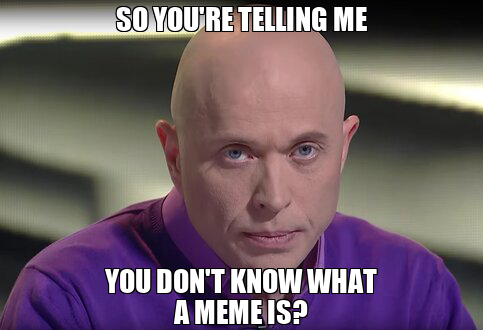

In [46]:
ch_lstm_model.cuda()

get_a_meme(
    model=ch_lstm_model, T=1.1, 
    beam_size=7,
    top_k=50,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='char',
    device='cuda'
)

### 2.2.2. LSTM with labels

In [108]:
#@markdown Load and build `ch_lstm_model_labels`

ckpt_path = 'LSTMDecoderWithLabelsChars.best.pth'

# download_from_gdrive(gdrive_id, ckpt_path)

model_class = FILE_TO_CLASS[ckpt_path]

ch_lstm_model_labels = load_and_build_model(ckpt_path, model_class)

Building CaptioningLSTMWithLabels model
Built and loaded CaptioningLSTMWithLabels model from LSTMDecoderWithLabelsChars.best.pth
# parameters: 7951431


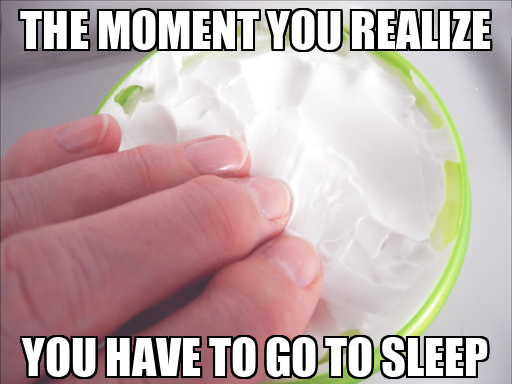

In [149]:
ch_lstm_model_labels.cuda()

get_a_meme(
    model=ch_lstm_model_labels, T=1.1, 
    beam_size=7,
    top_k=50,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption,
    # Use character input
    labels=labels_c, 
    mode='char',
    device='cuda'
    # device='cpu'
)

### 2.2.3. Tranformer with global image embedding

In [52]:
# Changed
# sample_seq = self.pad_index * torch.ones((1, max_len))
# to
# sample_seq = self.pad_index * torch.ones((1, max_len - 1))

In [53]:
#@markdown Load and build `ch_transformer_base_model`

ckpt_path = 'TransformerDecoderBaseChars.best.pth'
# download_from_gdrive(gdrive_id, ckpt_path)
model_class = FILE_TO_CLASS[ckpt_path]

ch_transformer_base_model = load_and_build_model(ckpt_path, model_class)

Building CaptioningTransformerBase model
Built and loaded CaptioningTransformerBase model from TransformerDecoderBaseChars.best.pth
# parameters: 10645575


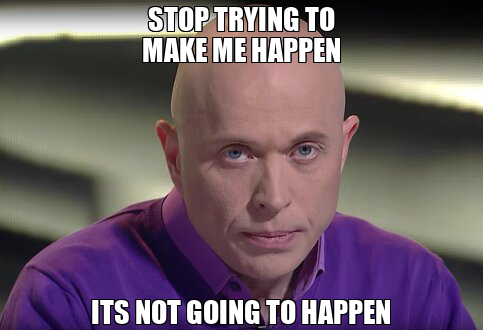

In [54]:
ch_transformer_base_model.cuda()

get_a_meme(
    model=ch_transformer_base_model, T = 1.1, 
    beam_size=7,
    # beam_size=20,
    top_k=50,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption,
    # caption = None, 
    labels = None, 
    mode='char',
    device ='cuda'
    # device ='cpu'
)

### 2.2.4. Tranformer with spacial image features

In [34]:
#@markdown Load and build `ch_transformer_model`

ckpt_path = 'TransformerDecoderChars.best.pth'
# download_from_gdrive(gdrive_id, ckpt_path)
model_class = FILE_TO_CLASS[ckpt_path]

ch_transformer_model = load_and_build_model(ckpt_path, model_class)

In [35]:
ch_transformer_model.cuda()

get_a_meme(
    model=ch_transformer_model, T = 1.1, 
    beam_size=7,
    top_k=50,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='char',
    device ='cuda'
    # device = 'cpu'
)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.